In [3]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Nirusan03\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [5]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\Nirusan03\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [7]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Nirusan03\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [6]:
# Importing the required files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ModuleNotFoundError: No module named 'pandas'

In [2]:
# Load the original dataset.
file_path = "E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Datasets\\Darknet.csv"
darknet_data = pd.read_csv(file_path)

# **Model Pre-processing**

In [3]:
#  Process 1 - Filter TLS-related traffic.
tls_ports = [443, 993, 995, 465, 8443]
tls_traffic = darknet_data[
    (darknet_data['Dst Port'].isin(tls_ports)) &  # Destination port is TLS-related.
    (darknet_data['Protocol'] == 6)              # Protocol is TCP.
]

In [4]:
#  Process 2 - Encoding the TLS traffic data.

# Creating object of Label Encoder class.
label_encoder = LabelEncoder()

# Encode string columns.
for column in tls_traffic.select_dtypes(include=['object']).columns:
    tls_traffic.loc[:, column] = label_encoder.fit_transform(tls_traffic[column])

In [5]:
#  Process 3- Scaling the TLS traffic data.

# Step 1: Identify Numeric Columns to Scale.
# Exclude columns that should not be scaled.
columns_to_exclude = ['Protocol', 'Dst Port']  # Add any additional columns to exclude if needed.
numeric_columns = tls_traffic.select_dtypes(include=['float64', 'int64']).columns.difference(columns_to_exclude)

# Step 2: Check and Replace Invalid Values.
# Replace infinity values with NaN.
tls_traffic.loc[:, numeric_columns] = tls_traffic[numeric_columns].replace([np.inf, -np.inf], np.nan)

# Fill NaN values with column means.
tls_traffic.loc[:, numeric_columns] = tls_traffic[numeric_columns].fillna(tls_traffic[numeric_columns].mean())

# Step 3: Scale Only the Selected Numeric Columns.
scaler = MinMaxScaler()
tls_traffic.loc[:, numeric_columns] = scaler.fit_transform(tls_traffic[numeric_columns])

# **Feature Selection and Feature Importance**

In [6]:
# Process 4 - Feature Selection.

# Define the target variable.
target_variable = 'Label'

# Calculate the correlation matrix.
correlation_matrix = tls_traffic.corr()

# Extract correlations with the target variable.
target_correlation = correlation_matrix[target_variable].drop(target_variable)

# Set a threshold for correlation (absolute value).
threshold = 0.1  # Adjust this based on your needs (e.g., 0.1 for weak correlation).

# Select features that are strongly correlated with the target.
selected_features = target_correlation[abs(target_correlation) > threshold]

# Remove identifier columns from the selected features.
identifiers = ['Flow ID', 'Src IP']
selected_features = selected_features.drop(index=identifiers, errors='ignore')

# Print the selected features and their correlation values.
print("Selected Features Based on Correlation with 'Label':")
print(selected_features)

# Update tls_traffic to retain only selected features and the target variable.
tls_traffic = tls_traffic[selected_features.index.tolist() + [target_variable]]

# Save the updated dataset for review.
tls_traffic.to_csv("4. Feature_Selected_Dataset_Without_Identifiers.csv", index=False)
print("Feature-selected dataset without identifiers saved as '4. Feature_Selected_Dataset_Without_Identifiers.csv'")

Selected Features Based on Correlation with 'Label':
Timestamp                -0.300921
Fwd Packet Length Mean    0.111124
Fwd PSH Flags             0.116855
SYN Flag Count           -0.177119
Fwd Segment Size Avg      0.111124
Subflow Fwd Packets       0.100899
FWD Init Win Bytes        0.295231
Bwd Init Win Bytes        0.269703
Fwd Seg Size Min          0.754610
Name: Label, dtype: float64
Feature-selected dataset without identifiers saved as '4. Feature_Selected_Dataset_Without_Identifiers.csv'


Feature Importance:
                  Feature  Importance
0               Timestamp    0.353997
8        Fwd Seg Size Min    0.236636
6      FWD Init Win Bytes    0.189628
7      Bwd Init Win Bytes    0.160596
1  Fwd Packet Length Mean    0.021654
4    Fwd Segment Size Avg    0.021053
3          SYN Flag Count    0.008305
2           Fwd PSH Flags    0.005236
5     Subflow Fwd Packets    0.002895


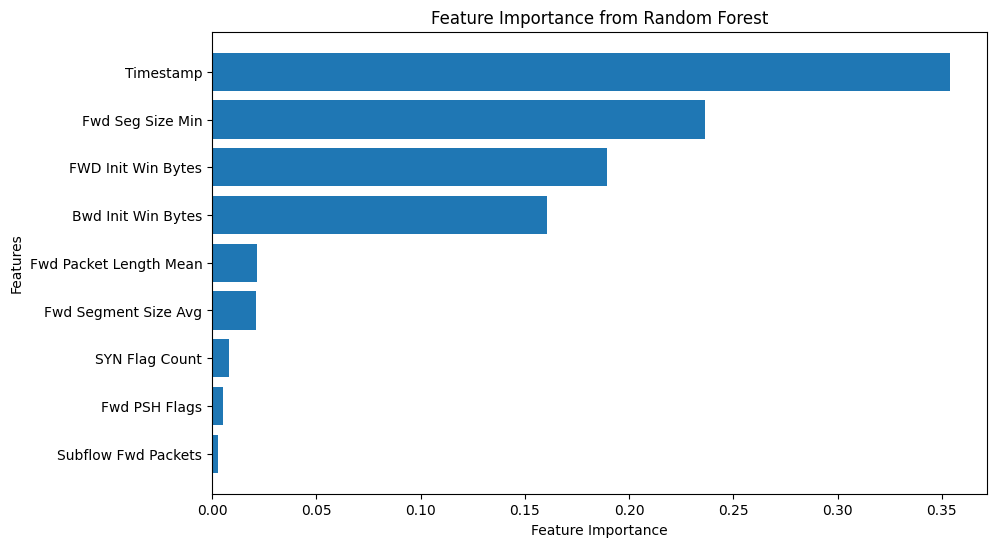

In [8]:
# Process 5 - Feature Importance validation.

# Ensure the target variable is properly encoded
tls_traffic['Label'] = tls_traffic['Label'].astype(int)  # Convert to integer if needed

# Separate features and target variable.
X = tls_traffic.drop(columns=['Label'])
y = tls_traffic['Label']

# Initialize and train the Random Forest model.
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Calculate feature importance.
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualisation.
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print feature importance.
print("Feature Importance:")
print(feature_importance_df)

# Plot feature importance.
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

# **Spliting Training and Testing Dataset**

In [9]:
# Process 6 - Splitting the dataset.
X = tls_traffic.drop(columns=['Label'])
y = tls_traffic['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training and testing datasets created.")

Training and testing datasets created.


In [11]:
pip uninstall protobuf

^C
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Import required libraries
import pennylane as qml
from pennylane import numpy as np
from sklearn.metrics import accuracy_score
import tensorflow as tf

print("Libraries installed and imported successfully!")

ImportError: cannot import name 'builder' from 'google.protobuf.internal' (c:\Users\Nirusan03\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\internal\__init__.py)

In [98]:
# Define the number of qubits based on the number of features
num_qubits = X_train.shape[1]

# Create a quantum device with the required number of qubits
dev = qml.device("default.qubit", wires=num_qubits)

# Define the quantum circuit with the QNode decorator
@qml.qnode(dev, interface="tf")  # Specify TensorFlow as the interface
def quantum_circuit(inputs, weights):
    # Embed classical data into the quantum circuit using AngleEmbedding
    qml.templates.AngleEmbedding(inputs, wires=range(num_qubits))
    # Apply trainable quantum layers with entanglement
    qml.templates.BasicEntanglerLayers(weights, wires=range(num_qubits))
    # Return the expectation value of PauliZ on the first qubit
    return qml.expval(qml.PauliZ(0))

# Print confirmation
print("Quantum device and circuit defined successfully!")

# Test the quantum circuit
inputs = tf.random.uniform((num_qubits,))
weights = tf.random.uniform((2, num_qubits))  # Shape matches num_layers and num_qubits
result = quantum_circuit(inputs, weights)
print("Quantum circuit output:", result)

Quantum device and circuit defined successfully!
Quantum circuit output: tf.Tensor(0.10291146952688113, shape=(), dtype=float64)


In [99]:
# Define the weight shape for the quantum circuit
num_layers = 2  # Number of layers in the quantum circuit
weight_shape = {"weights": (num_layers, num_qubits)}

# Create a custom Keras layer that integrates the quantum circuit
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        # Initialize trainable weights for the quantum circuit
        self.q_weights = self.add_weight(
            name="q_weights",
            shape=weight_shape["weights"],
            initializer="random_normal",
            trainable=True,
        )

    def call(self, inputs):
        # Function to execute the quantum circuit
        def circuit_execution(input_sample):
            # Call the quantum circuit
            result = quantum_circuit(input_sample, self.q_weights)
            return tf.convert_to_tensor(result, dtype=tf.float32)

        # Apply the quantum circuit to each input sample in the batch
        outputs = tf.map_fn(
            circuit_execution, inputs, fn_output_signature=tf.float32
        )
        # Set the output shape explicitly for compatibility
        outputs.set_shape((inputs.shape[0], num_qubits))
        return outputs

    def compute_output_shape(self, input_shape):
        # The output shape is (batch_size, num_qubits)
        return (input_shape[0], num_qubits)

# Define the hybrid Quantum-Classical model
def create_hybrid_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(num_qubits,)),  # Input layer matching the number of features
        QuantumLayer(),                      # Quantum layer for feature extraction
        tf.keras.layers.Dense(1, activation="sigmoid"),  # Dense layer for binary classification
    ])
    return model

# Create the model
hybrid_model = create_hybrid_model()

# Print the model summary
hybrid_model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ quantum_layer_17 (QuantumLayer) │ (None, 9)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28 (112.00 B)

 Trainable params: 28 (112.00 B)

 Non-trainable params: 0 (0.00 B)

In [100]:
# Compile the model
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer with learning rate
    loss="binary_crossentropy",  # Binary cross-entropy loss for binary classification
    metrics=[
        "accuracy", 
        tf.keras.metrics.Precision(),  # Track precision
        tf.keras.metrics.Recall(),  # Track recall
    ]
)

print("Model compiled successfully!")

Model compiled successfully!


In [102]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",  # Use the .keras extension for the filepath
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1
)

# Train the model
history = hybrid_model.fit(
    X_train,
    y_train,
    epochs=20,  # Number of training epochs
    batch_size=32,  # Batch size
    validation_split=0.2,  # Use 20% of the training data for validation
    verbose=1,  # Display training progress
    callbacks=[early_stopping, checkpoint, lr_scheduler]  # Add callbacks
)

print("Model training complete!")

Epoch 1/20


ImportError: Exception encountered when calling QuantumLayer.call().

[1mautoray couldn't find function 'asarray' for backend 'keras'.[0m

Arguments received by QuantumLayer.call():
  • inputs=tf.Tensor(shape=(None, 9), dtype=float32)